In [2]:
include("../src/cliff7.jl")
using PyPlot
using Profile

In [40]:
function cc_adam_gate!(state, b, i, j, p)
    ms = size(state, 1)==size(state, 2) ? fps_measurement! : measurement!
    cliff = random_clifford(2b)
    rg = union(b*i-b+1:b*i, b*j-b+1:b*j)
    clifford_action!(cliff, state, rg)
    if rand() < p
        obs = (0, Bool[1, 0])
        for k in b*i-b+1:b*i
            ms(state, obs, [k])
        end
    end
    if rand() < p
        obs = (0, Bool[1, 0])
        for k in b*j-b+1:b*j
            ms(state, obs, [k])
        end
    end
    return nothing
end

function cc_ee_sim(n, b, cut, p_list, n_step, step_size, burnin, n_average, periodic)
    result = zeros(length(p_list), n_step)
    for (k, p) in enumerate(p_list)
        for _ in 1:n_average
            state = all_up(n*b)
            for _ in 1:burnin
                for ini in [1, 2]
                    for i in ini : 2 : (periodic ? n : n-1)
                        j = i==n ? 1 : i+1
                        cc_adam_gate!(state, b, i, j, p)
                    end
                end
            end
            for t in 1:n_step
#                 result[k, t] += left_ee_on_all_cuts(state)[b*cut+1]
                for _ in 1:step_size
                    for ini in [1, 2]
                        for i in ini : 2 : (periodic ? n : n-1)
                            j = i==n ? 1 : i+1
                            cc_adam_gate!(state, b, i, j, p)
                        end
                    end
                end
            end
        end
    end
    result ./= n_average
    return result
end

cc_ee_sim (generic function with 1 method)

In [37]:
n = 128
b = 2
cut = div(n, 2)
p_list = [0.2]
n_step = 128
step_size = 1
burnin = 0
n_average = 100
periodic = true
nn = 30

30

In [38]:
Profile.clear()
Profile.init(Int(1e7), 0.01)
@profile cc_ee_sim(n, b, cut, p_list, n_step, step_size, burnin, n_average, periodic)

1×128 Array{Float64,2}:
 0.0  2.52  4.62  6.26  8.03  9.61  11.07  …  34.8  34.79  34.85  34.7  34.77

In [58]:
function rand_prod_state(n)
    xz = zeros(Bool, 2n, 2n)
    s = rand([0, 2], 2n)
    for i in 1:n
        a = rand()
        if a < 1/3
            xz[i, 2i-1] = true
            xz[i+n, 2i] = true
        elseif a < 2/3
            xz[i, 2i] = true
            xz[i+n, 2i-1] = true
        else
            xz[i, 2i-1] = true
            xz[i, 2i] = true
            xz[i+n, 2i] = true
            
            s[i] += 1
        end
    end
    return StabState(xz, s, n)
end
        

function cal_cc_ee(n, avg, ini_state, gate)
    ee = zeros(n+1)
    ee2 = zeros(n+1)
    for _ in 1:avg
        state = ini_state(n)
        cl = gate(n)
        clifford_action!(cl, state, 1:n)
        tmp = left_ee_on_all_cuts(state)
        ee += tmp
        ee2 += tmp.^2
    end
    Eee = ee ./ avg
    Eee2 = ee2 ./ avg
    Dee = sqrt.(Eee2 - Eee.^2)
    return Eee, Dee
end


function QEC_sim(n, k, n_loss, ini_state, gate)
    # [k-ref | n-physical]
    state = ini_state(n+k)
    for i in 1:k
        state.xz[i, 2i-1] = true
        state.xz[i+k, ]
    end
    gate = gate(n)
    clifford_action!(cl, state, k+1:k+n)
    mi = mutual_info(state, 1:k, k+n_loss+1:k+n)
    mn = mutual_neg(state, 1:k, k+n_loss+1:k+n)
    return mi-2mn, div(mn, 2)
end

cal_ee (generic function with 2 methods)

In [59]:
avg = 10000
n = 32

Eee1, Dee1 = cal_cc_ee(n, avg, rand_prod_state)
Eee2, Dee2 = cal_ee(n, avg, rand_prod_state)

([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 8.9999  …  9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009999499987268705  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

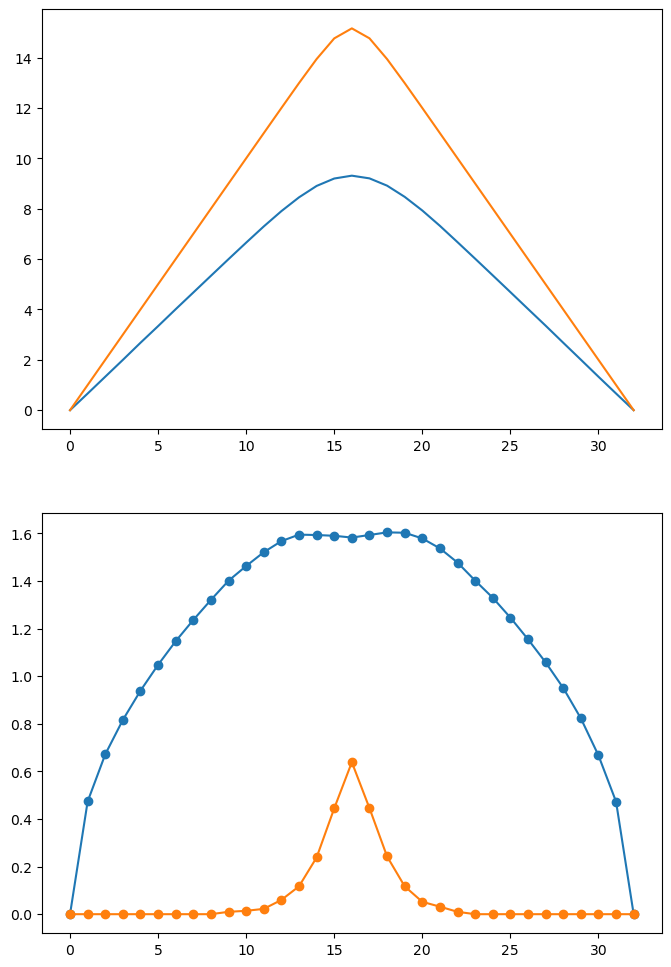

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000611A1070>

In [61]:
fg, ax = subplots(2, figsize=(8, 12))

ax[1].plot(Eee1)
ax[1].plot(Eee2)

ax[2].plot(Dee1, "-o")
ax[2].plot(Dee2, "-o")

# ax[2].set_yscale("log")